In [1]:
import os
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,6)

In [14]:
# goes through all trials in the folder and returns the mean slope deviation, mean transactions per second, 
# mean block amount and mean transactions per block
def calculate_trial_means(folder):
    
    trials = os.listdir(directory + folder)
    differences = []

    for individual_trial in trials:
        if individual_trial == ".ipynb_checkpoints":
            continue
        current_path = directory + folder + "/" + individual_trial + "/"
        differences.append(results_individual_trial(current_path))
    
    differences_df = pd.DataFrame(differences)
    slope = differences_df['slope_diff'].agg(['mean']).fillna(0).to_dict()
    tx_per_sec = differences_df['tx_per_sec'].agg(['mean']).fillna(0).to_dict()
    block_amount = differences_df['block_amount'].agg(['mean']).fillna(0).to_dict()
    mean_tx_per_block = differences_df['mean_tx_per_block'].agg(['mean']).fillna(0).to_dict()
    
    mean = {'mean_slope': round(slope['mean'], 4), 'mean_tx': round(tx_per_sec['mean'], 4),
                'mean_block_amount': round(block_amount['mean'], 4),
                'mean_tx_per_block': round(mean_tx_per_block['mean'], 4)}
    return mean


In [15]:
# calculates the linear regressions for submits and confirmations
# returns transactions per second, slope deviation, block amount and 
# mean transactions per block for the individual trial and adds them to individual trial dataframe
def results_individual_trial(current_path):

    # Submissions
    submits = pd.read_json(path_or_buf=current_path + 'submits.json', convert_dates=False)
    start_time = submits['timestamp'].values[0]
    submits['timestamp'] = (submits['timestamp'] - start_time) / 1000
    submits = submits.drop(columns = ['txHash'])
    submits = submits.set_index('index')
    
    # Balance changes
    balance_change = pd.read_json(path_or_buf=current_path + 'balanceChanges.json', convert_dates=False)
    balance_change['timestamp'] = (balance_change['timestamp'] - start_time) / 1000
    balance_change.loc[-1] = [0, balance_change['timestamp'].values[0]]
    balance_change.shift(1)
    balance_change.sort_index(inplace=True) 
    balance_change = balance_change.set_index('amount')
        
    # All blocks
    all_blocks = pd.read_json(path_or_buf=current_path + 'allTxBlocks.json', convert_dates=False)
    block_amount = len(all_blocks)
    mean_tx_per_block = all_blocks.agg(['mean', 'sem']).fillna(0).to_dict()
    
    # Linear regression
    # Submit slope
    x_submit = submitEth.timestamp.values.reshape(-1,1)
    y_submit = submitEth.index.values
    reg_submit = LinearRegression().fit(x_submit, y_submit)
    submit_slope = reg_submit.coef_
    
    # Balance slope
    x_balance = balanceEth.timestamp.values.reshape(-1,1)
    y_balance = balanceEth.index.values
    reg_balance = LinearRegression().fit(x_balance, y_balance)
    y_balance_pred = reg_balance.predict(x_balance)
    
    slope_difference = abs((reg_balance.coef_ / reg_submit.coef_) - 1)
    
    global results_all_data_points
    results_all_data_points = results_all_data_points.append(
        {'tx_per_sec': reg_submit.coef_[0], 
         'slope_diff': slope_difference[0],
         'block_amount': block_amount,
         'mean_tx_per_block': mean_tx_per_block[0]['mean']}, 
        ignore_index=True
    )
    return {'tx_per_sec': reg_submit.coef_[0], 
            'slope_diff': slope_difference[0], 
            'block_amount': block_amount, 
            'mean_tx_per_block': mean_tx_per_block[0]['mean']}

In [18]:
global directory
directory = "../results/ethereum/baseload_0/"
files = os.listdir(directory)

# dataframe with data for the mean results of one TPS value (based on balance changes)
results_avg = pd.DataFrame(
    columns = ['mean_slope', 'mean_tx', 'mean_block_amount', 'mean_tx_per_block', 'trial_folder']
)

# dataframe with data for each individual trial (based on balance changes)
results_all_data_points = pd.DataFrame(columns = ['tx_per_sec', 'slope_diff', 'block_amount', 'mean_tx_per_block'])

# goes through all subfolders and calculates mean values
for sub_folder in files:
    if sub_folder == ".ipynb_checkpoints":
        continue
    mean = calculate_trial_means(sub_folder)
    mean['trial_folder'] = sub_folder
    results_avg = results_avg.append(mean_sem, ignore_index=True)
    
results_avg = results_avg.set_index('trial_folder')
results_avg = results_avg.sort_values(by=['mean_tx'])

results_all_data_points = results_all_data_points.sort_values(by=['tx_per_sec'])

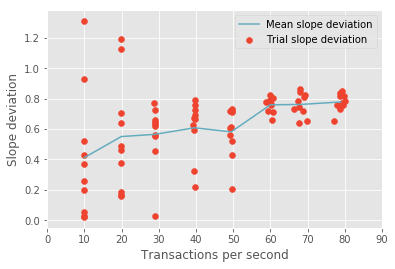

In [10]:
# plots mean slope deviation
fig = plt.figure()
ax=fig.add_subplot(111)

ax.plot(results_avg['mean_tx'], results_avg['mean_slope'], label='Mean slope deviation', color='#63ACBE')
ax.scatter(results_all_data_points['tx_per_sec'], results_all_data_points['slope_diff'], label='Trial slope deviation', color='#EE442F')

ax.set_ylabel('Slope deviation')
ax.set_xlabel('Transactions per second')
ax.xaxis.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])


plt.legend()
plt.show()

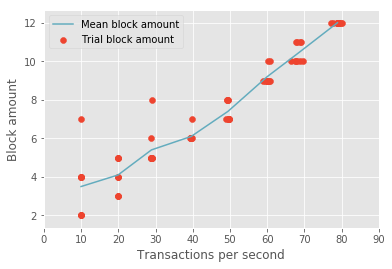

In [11]:
# plots mean block amount
fig = plt.figure()
ax=fig.add_subplot(111)

ax.plot(results_avg['mean_tx'], results_avg['mean_block_amount'], label='Mean block amount', color='#63ACBE')
ax.scatter(results_all_data_points['tx_per_sec'], results_all_data_points['block_amount'], label='Trial block amount', color='#EE442F')

ax.set_ylabel('Block amount')
ax.set_xlabel('Transactions per second')
ax.xaxis.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.legend()
plt.show()

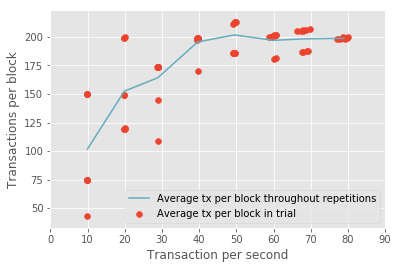

In [12]:
# plots mean transactions per block
fig = plt.figure()
ax=fig.add_subplot(111)

ax.plot(results_avg['mean_tx'], results_avg['mean_tx_per_block'], label='Average tx per block throughout repetitions', color='#63ACBE')
ax.scatter(results_all_data_points['tx_per_sec'], results_all_data_points['mean_tx_per_block'], label='Average tx per block in trial', color='#EE442F')

ax.set_ylabel('Transactions per block')
ax.set_xlabel('Transaction per second')
ax.xaxis.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.legend()
plt.show()